## Map Sepsis PBMCs onto our cross-inflamed/disease tissue immune cell reference
### Fan Zhang
----

## Abstract:
### 1) As we know that there could be cell type/state differences between tissue and blood. It would be even challenging to map cells from blood to the same cell states from different tissue sources, technologies, and diseased donors using single-cell transcriptomics.
### 2) We built a > 307,000 immune cell reference by unbiasedly integrating cells from multiple inflamed and diseased tissues and COVID-19 BALFs. It can be served as a reference to study similarities and differences cross different clinical conditions. 
### 3) One application of this reference is to query "new" cells from an external dataset. 
### 4) As a proof of concept, we are able to map a Sepsis PBMC single-cell transcriptomic dataset to our tissue-level reference and show the highly accurate cell type prediction using Symphony. 
### - We also map fine-grained cell states with higher granuality to the same cell states embedded in our reference. 
### - We show a clear separation of MS1 and MS3 (other MS subsets) when they are mapped onto your tissue macrophages, which remains the query (original) cell state definition, and reveals interesting transcriptomic inflammatory/non-inflammatory macrophage similarities between blood and tissue.
### - Some quick observations: we assign sepsis BS3 to the plasma cells in our reference, since BS3 indeed highly expressed plasma cell marker genes like MZB1 and XBP1 from their original paper. We also assign sepsis TS3 to the cycling T cells in our reference, which makes sense since TS3 expressed MKI67, a typical proliferating marker gene.
-----

## Below is our notebook as a proof of concept:
### - Reference: [Zhang, et al. 2021. In Review](https://www.biorxiv.org/content/10.1101/2020.08.05.238360v1)
### - Query: [Reyes, et al. Nature Medicine, 2020](https://www.nature.com/articles/s41591-020-0752-4)
### - Mapping method (Symphony): [Kang, et al, bioRxiv, 2021. In Review](https://www.biorxiv.org/content/10.1101/2020.11.18.389189v2)
----

In [5]:
suppressPackageStartupMessages({
    library(harmony)
    library(tidyverse)
    library(data.table)
    library(matrixStats)
    library(patchwork)
    library(Matrix)
    library(uwot)
    library(plyr)
    library(dplyr)
    library(singlecellmethods)
    library(class) # for knn
    library(Seurat)
    library(RANN) # for nn
    library(reshape2) # for nn
    library(GGally) # for ggpairs
    library(symphony)
    library(magrittr)
    library(gridExtra)
    library(cowplot)
    library(reticulate)
    library(MASS)
    library(grid)
    require(gdata)
    library(Rcpp)
    library(scales)
    library(irlba)
    library(parallel)
    library(pbapply)
    library(pheatmap)
    library(igraph)
    library(viridis)
    
    # for figures
    library(ggrastr)
    library(ggpubr)
    library(ggplot2)
    library(ggthemes)
    library(RColorBrewer)
    library(ggrepel)
})

fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

meta_colors <- list(
    "broad_cell_type" = c(
        'B cells' =  "#D9D9D9", 
        'Plasma cells' = "#BDBDBD" ,
        'Cycling B' =  "#737373", 
        'NK' =  "#D0D1E6" ,
        'Cycling T' = "#A6BDDB" ,
        'T cells' ="#b4d8db",
        'Mast cells' =  "#F0F0F0" ,
        'Macrophages/monocytes' = "#FED9A6",
        'DC' = "#E5D8BD"
     )
)


In [2]:
# Functions
FindVariableGenesBatch <- function(exprs_mat, meta_df, genes_exclude = NULL, ngenes_use = 1e3, expr_min = .1) {
    if (!is.null(genes_exclude)) {
        genes_use <- setdiff(row.names(exprs_mat), genes_exclude)
    }
    x_res <- split(meta_df$cell, meta_df$sample) %>% lapply(function(x) {
        FindVariableGenesSeurat(exprs_mat[genes_use, x]) %>% 
            subset(gene.mean >= expr_min) %>% 
            tibble::rownames_to_column("gene") %>% 
            dplyr::arrange(-gene.dispersion) %>%
            head(ngenes_use)
    })
    data.table(Reduce(rbind, x_res))[, .N, by = gene][order(-N)]    
}



FindVariableGenesSeurat <- function (data, x.low.cutoff = 0.1, x.high.cutoff = 8,
                                     y.cutoff = 1, y.high.cutoff = Inf, num.bin = 0,
                                     binning.method = "equal_width", sort.results = TRUE,
                                     display.progress = TRUE, ...)
{
    genes.use <- rownames(data)
    if (class(data) != "dgCMatrix") {
        data <- as(as.matrix(data), "dgCMatrix")
    }
    ## (1) get means and variances
    gene.mean <- FastExpMean(data, display.progress)
    names(gene.mean) <- genes.use
    gene.dispersion <- FastLogVMR(data, display.progress)
    names(gene.dispersion) <- genes.use

    gene.dispersion[is.na(x = gene.dispersion)] <- 0
    gene.mean[is.na(x = gene.mean)] <- 0

    mv.df <- data.frame(gene.mean, gene.dispersion)
    rownames(mv.df) <- rownames(data)

    ## (OPTIONAL) do the binning correction
    if (num.bin > 0) {
      if (binning.method == "equal_width") {
          data_x_bin <- cut(x = gene.mean, breaks = num.bin)
      }
      else if (binning.method == "equal_frequency") {
          data_x_bin <- cut(x = gene.mean, breaks = c(-1, quantile(gene.mean[gene.mean >
              0], probs = seq(0, 1, length.out = num.bin))))
     }
      else {
          stop(paste0("Invalid selection: '", binning.method,
              "' for 'binning.method'."))
      }
      names(x = data_x_bin) <- names(x = gene.mean)
      mean_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = mean)
      sd_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = sd)
      gene.dispersion.scaled <- (gene.dispersion - mean_y[as.numeric(x = data_x_bin)])/sd_y[as.numeric(x = data_x_bin)]
      gene.dispersion.scaled[is.na(x = gene.dispersion.scaled)] <- 0
      ##names(gene.dispersion.scaled) <- names(gene.mean)

      mv.df$gene.dispersion.scaled <- gene.dispersion.scaled
    }

    return(mv.df)
}

environment(FindVariableGenesSeurat) <- asNamespace("Seurat")

ScaleDataSeurat <- function (data.use, margin = 1, scale.max = 10,
                                block.size = 1000) {

    if (margin == 2) data.use %<>% t
    max.block <- ceiling(nrow(data.use)/block.size)

    ## Define data and functions to use in sparse and dense cases
    if (class(data.use) == "dgCMatrix" | class(data.use) == "dgTMatrix") {
        scale_fxn <- function(x) {
            FastSparseRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
        }
    } else {
        scale_fxn <- function(x) {
            FastRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
       }
        data.use <- as.matrix(data.use)
    }

    ## Do scaling, at once or in chunks
    if (max.block == 1) {
        scaled.data <- scale_fxn(data.use)
    } else {
        scaled.data <- matrix(NA, nrow(data.use), ncol(data.use))
        for (i in 1:max.block) {
            idx.min <- (block.size * (i - 1))
            idx.max <- min(nrow(data.use), (block.size * i - 1) + 1)
            my.inds <- idx.min:idx.max
            scaled.data[my.inds, ] <- scale_fxn(data.use[my.inds, , drop = F])
        }
    }

    colnames(scaled.data) <- colnames(data.use)
    row.names(scaled.data) <- row.names(data.use)
    scaled.data[is.na(scaled.data)] <- 0
    if (margin == 2) scaled.data %<>% t
    return(scaled.data)
}
environment(ScaleDataSeurat) <- asNamespace("Seurat")


fig.size <- function(height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

SingleFeaturePlotSeurat <- function (data.use, feature, data.plot, pt.size, pch.use, cols.use,
    dim.codes, min.cutoff, max.cutoff, coord.fixed, no.axes,
    no.title = FALSE, no.legend, dark.theme, vector.friendly = FALSE,
    png.file = NULL, png.arguments = c(10, 10, 100))
{
    if (vector.friendly) {
        previous_call <- blank_call <- png_call <- match.call()
        blank_call$pt.size <- -1
        blank_call$vector.friendly <- FALSE
        png_call$no.axes <- TRUE
        png_call$no.legend <- TRUE
        png_call$vector.friendly <- FALSE
        png_call$no.title <- TRUE
        blank_plot <- eval(blank_call, sys.frame(sys.parent()))
        png_plot <- eval(png_call, sys.frame(sys.parent()))
        png.file <- SetIfNull(x = png.file, default = paste0(tempfile(),
            ".png"))
        ggsave(filename = png.file, plot = png_plot, width = png.arguments[1],
            height = png.arguments[2], dpi = png.arguments[3])
        to_return <- AugmentPlot(blank_plot, png.file)
        file.remove(png.file)
        return(to_return)
    }
    idx.keep <- which(!is.na(data.use[feature, ]))
    data.gene <- data.frame(data.use[feature, idx.keep])
#     data.gene <- na.omit(object = data.frame(data.use[feature,
#         ]))
    min.cutoff <- SetQuantile(cutoff = min.cutoff, data = data.gene)
    max.cutoff <- SetQuantile(cutoff = max.cutoff, data = data.gene)
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    data_plot <- data.plot[idx.keep, ]
    data_plot$gene <- data.gene
    if (length(x = cols.use) == 1) {
        brewer.gran <- brewer.pal.info[cols.use, ]$maxcolors
    }
    else {
        brewer.gran <- length(x = cols.use)
    }
    if (all(data.gene == 0)) {
        data.cut <- 0
    }
    else {
        data.cut <- as.numeric(x = as.factor(x = cut(x = as.numeric(x = data.gene),
            breaks = brewer.gran)))
    }
    data_plot$col <- as.factor(x = data.cut)
    p <- data_plot %>%
        dplyr::arrange(col) %>%
        ggplot(mapping = aes(x = x, y = y))
    if (brewer.gran != 2) {
        if (length(x = cols.use) == 1) {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_brewer(palette = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
        else {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_manual(values = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
    }
    else {
        if (all(data_plot$gene == data_plot$gene[1])) {
            warning(paste0("All cells have the same value of ",
                feature, "."))
            p <- p + geom_point(color = cols.use[1], size = pt.size,
                shape = pch.use)
        }
        else {
            p <- p + geom_point(mapping = aes(color = gene),
                size = pt.size, shape = pch.use) + scale_color_viridis(option = "plasma", end = .9
    )
        }
    }
    if (dark.theme) {
        p <- p + DarkTheme()
    }
    if (no.axes) {
        p <- p + theme(axis.line = element_blank(), axis.text.x = element_blank(),
            axis.text.y = element_blank(), axis.ticks = element_blank(),
            axis.title.x = element_blank(), axis.title.y = element_blank())
        if (!no.title)
            p <- p + labs(title = feature, x = "", y = "")
        if (no.title)
            p <- p + labs(x = "", y = "")
    }
    else {
        if (no.title)
            p <- p + labs(x = dim.codes[1], y = dim.codes[2])
        if (!(no.title))
            p <- p + labs(title = feature) + labs(x = "", y = "")
    }
    if (no.legend) {
        p <- p + theme(legend.position = "none")
    }
    if (coord.fixed) {
        p <- p + coord_fixed()
    }
    return(p)
}
environment(SingleFeaturePlotSeurat) <- asNamespace("Seurat")

PlotFeatures <- function(umap_use, features_plot, exprs_use, cells_use, ncols, pt_size = .5, pt_shape = ".", q_lo = "q10", q_hi = "q90") {
    if (missing(cells_use)) cells_use <- 1:nrow(umap_use)
    if (missing(ncols)) ncols <- round(sqrt(length(features_plot)))
    
    plt_list <- lapply(features_plot, function(feature_use) {
        SingleFeaturePlotSeurat(exprs_use[, cells_use], feature_use, data.frame(x = umap_use[cells_use, 1], y = umap_use[cells_use, 2]),
                                pt.size = pt_size, pch.use = pt_shape, cols.use = c("lightgrey", "blue"),
                                dim.codes = c("UMAP 1", "UMAP 2"), min.cutoff = c(q10 = q_lo), max.cutoff = c(q90 = q_hi),
                                coord.fixed = FALSE, no.axes = FALSE, dark.theme = FALSE, no.legend = TRUE)
    })
    plot_grid(plotlist = plt_list, ncol = ncols)
    #return(plt_list)
}

BuildSNNSeurat <- function (data.use, k.param = 30, prune.SNN = 1/15, nn.eps = 0) {
    my.knn <- nn2(data = data.use, k = k.param, searchtype = "standard", eps = nn.eps)
    nn.ranked <- my.knn$nn.idx

    snn_res <- ComputeSNN(nn_ranked = nn.ranked, prune = prune.SNN)
    rownames(snn_res) <- row.names(data.use)
    colnames(snn_res) <- row.names(data.use)
    return(snn_res)
}
environment(BuildSNNSeurat) <- asNamespace("Seurat")

NormalizeDataSeurat <- function(A, scaling_factor = 1e4, do_ftt = FALSE) {
	A@x <- A@x / rep.int(Matrix::colSums(A), diff(A@p))
    A@x <- scaling_factor * A@x
    if (do_ftt) {
        A@x <- sqrt(A@x) + sqrt(1 + A@x)
    } else {
        A@x <- log(1 + A@x)
    }
	return(A)
}

## Reference building start

In [7]:
## Read aggregated data matrix
ref_exp_norm = readRDS("/data/srlab1/fzhang/results/2020_05_14_COVID19_RA_SLE_UC_Crohn_MS_lung/exprs_norm_COVID19_AMP_RA_SLE_Rahul_Lung_UC_CD_307084cells.rds")
ref_meta = readRDS("/data/srlab1/fzhang/results/2020_05_14_COVID19_RA_SLE_UC_Crohn_MS_lung/meta_all_COVID19_AMP_RA_SLE_Rahul_Lung_UC_CD_307084cells.rds")

In [8]:
# Each donor sample will be one batch.
# Note: there are only around 30-50 cells per sample for CEL-seq2 dataset, 
# so we consider the cells from synovium CEL-seq2 as one batch and kidney CEL-seq2 as another batch
ref_meta$batch <- ref_meta$sample
ref_meta[which(ref_meta$dataset %in% c("AMP RA")),]$batch <- "AMP RA" # technology tissue
ref_meta[which(ref_meta$dataset %in% c("AMP SLE")),]$batch <- "AMP SLE" # technology tissue

In [5]:
# Read in variable genes
vargenes_fan = readRDS('/data/srlab1/fzhang/results/2020_05_14_COVID19_RA_SLE_UC_Crohn_MS_lung/tissue_immune_integration_var_genes.rds')

## Preprocessing steps

In [10]:
## Scale expression to z-scores across cell types
exprs_scaled <- ref_exp_norm[vargenes_fan, ] %>% ScaleDataSeurat() 

In [12]:
exprs_scaled[1:5, 1:5]

,S006_L1Q1_A03,S006_L1Q1_A05,S006_L1Q1_A07,S006_L1Q1_A09,S006_L1Q1_A11
CD74,0.1183395,-0.1040244,-0.007996025,-1.6865243,0.4511563
FTL,-2.4591985,-2.4591985,-1.391826429,-2.4591985,-2.4591985
HLA-DRA,-1.0017991,-0.2527994,-1.001799073,-0.2116087,-1.0017991
TMSB4X,-0.1325115,-0.7702992,-0.583399608,-0.6133693,-0.2994012
CCL4,-0.4893175,-0.4893175,-0.489317477,-0.4893175,-0.4893175


In [13]:
## PCA for top 20 PCs or top 10 PCs, depending on how heterogeneous the aggregated dataset is
pca_res <- irlba::prcomp_irlba(t(exprs_scaled), 10)

In [14]:
saveRDS(pca_res, "pca_res_COVID19_RA_Rahul_SLE_UC_Crohn_MS_lung.rds")
# pca_res = readRDS("pca_res_COVID19_RA_Rahul_SLE_UC_Crohn_MS_lung.rds")
loadings = as.data.frame(pca_res$rotation)
pca_res$x[1:5, 1:10]

PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0.06510066,-0.1974917,0.07440059,0.1595101,0.1670999,-0.06303439,0.031739905,-0.006912267,0.02636409,0.009292855
0.10634761,-0.2200344,0.10178788,0.1853691,0.1463358,-0.02500254,0.057598354,0.004215855,0.06233092,0.020617692
0.08124109,-0.1921700,0.06070047,0.1515644,0.1714388,-0.04522398,-0.027780989,0.040817787,0.02425381,0.021045096
0.07578267,-0.2496121,0.09281371,0.1725066,0.1741893,-0.07826913,0.051583740,-0.014926797,0.04942183,0.010852900
0.10839920,-0.2039024,0.06562772,0.1582105,0.1244432,-0.02511453,0.006034785,0.031648703,0.03645302,0.009046679


Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 15354200)”Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 15354200)”Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 15354200)”Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 15354200)”Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 15354200)”Warning message:
“Quick-TRANSfer stage steps exceeded maximum (= 15354200)”Harmony 1/20
Harmony 2/20
Harmony 3/20
Harmony 4/20
Harmony 5/20
Harmony 6/20
Harmony 7/20
Harmony 8/20
Harmony 9/20
Harmony 10/20
Harmony 11/20
Harmony 12/20
Harmony 13/20
Harmony 14/20
Harmony 15/20
Harmony 16/20
Harmony 17/20
Harmony 18/20
Harmony 19/20
Harmony 20/20


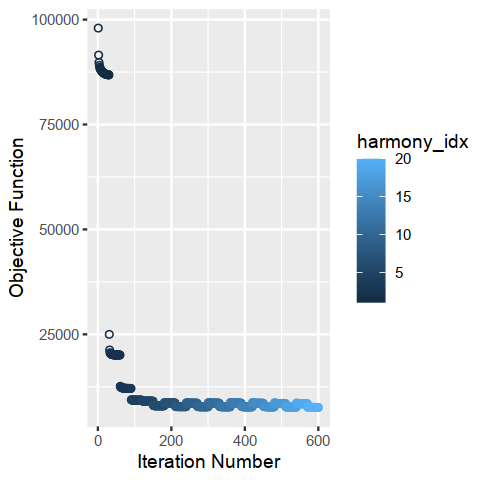

In [15]:
# Harmony for batch effect correction
fig.size(4, 4)
harmony <- HarmonyMatrix(t(pca_res$x), ref_meta, do_pca=FALSE,
                         c("batch", "dataset"), theta = c(2,2), return_object = TRUE,
                         epsilon.cluster = -Inf,
                         epsilon.harmony = -Inf,
                         max.iter.cluster = 30,
                         max.iter.harmony = 20,
                         plot_convergence = T)

In [35]:
# saveRDS(harmony, "/data/srlab2/fzhang/results/2020_12_29_genome_medicine_revision/ref_harmony.rds")

In [19]:
# Compress Harmony reference into a Symphony reference
reference = symphony::buildReferenceFromHarmonyObj(
                           harmony,            # output object from HarmonyMatrix()
                           ref_meta,
                           vargenes_means_sds,     # gene names, means, and std devs for scaling
                           loadings,               # genes x PCs
                           verbose = TRUE,
                           do_umap = TRUE,         # Set to TRUE only when UMAP model was saved for reference
                           save_uwot_path = '/data/srlab2/fzhang/results/2020_12_29_genome_medicine_revision/ref_umap_cosnorm_10d')

Save metadata, vargenes (S), and loadings (U)
Save R, Z_orig, Z_corr, and betas from Harmony object
Calculate final L2 normalized reference centroids (Y_cos)
Calculate reference compression terms (Nr and C)
UMAP
Warning message:
“invalid uid value replaced by that for user 'nobody'”Saved uwot model
Finished nicely.


In [21]:
colnames(reference$umap$embedding) = c('UMAP1', 'UMAP2')
saveRDS(reference, '/data/srlab2/fzhang/results/2020_12_29_genome_medicine_revision/ref_symphony_cosnorm_10d.rds')

In [19]:
# Load the reference
reference = readRDS('/data/srlab2/fzhang/results/2020_12_29_genome_medicine_revision/ref_symphony_cosnorm_10d.rds')

In [6]:
umap_labels = cbind(reference$meta_data, reference$umap$embedding)
dim(umap_labels)

[1] 307084     50

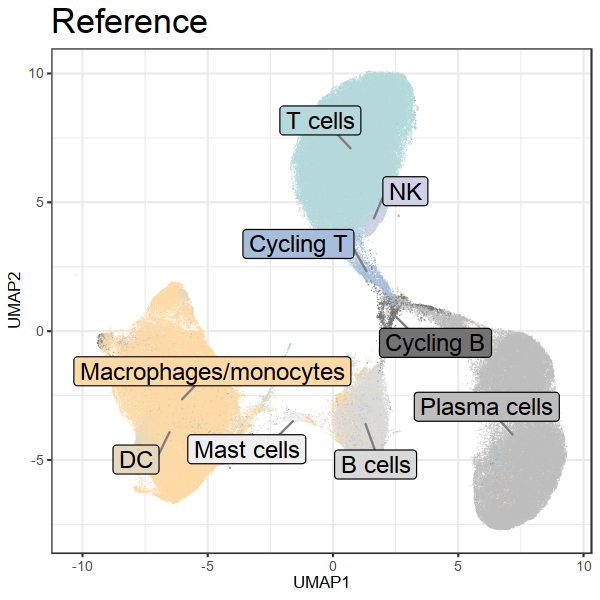

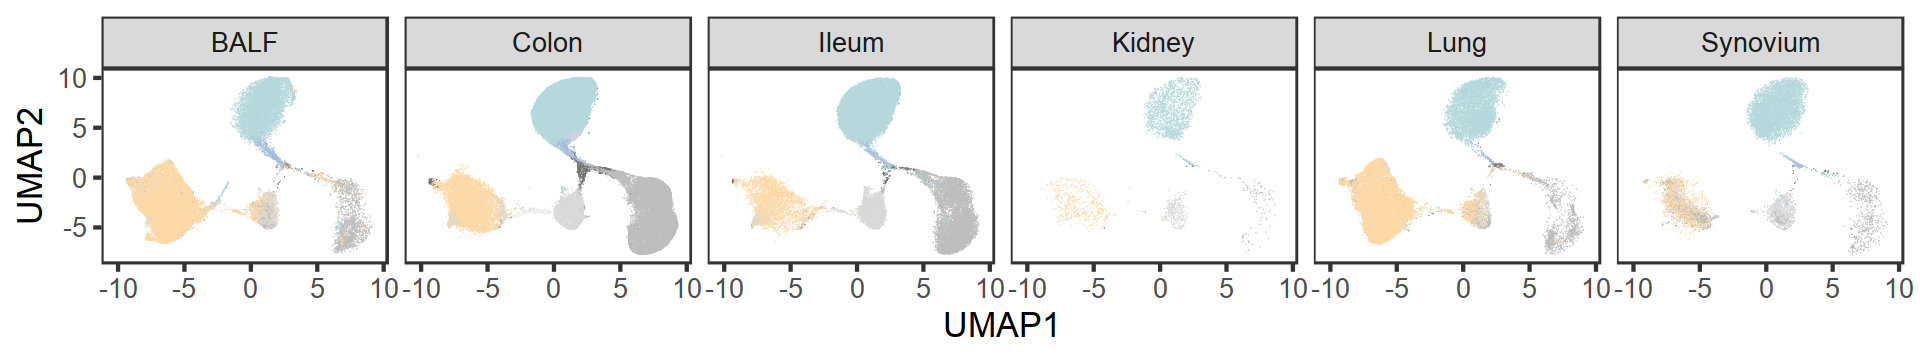

In [68]:
## Viz the reference
fig.size(5, 5)
cluster_center <- umap_labels %>%
                  group_by(broad_cell_type) %>%
                  summarise_at(vars(UMAP1, UMAP2), funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)
cluster_center$broad_cell_type_nk_dc <- as.character(cluster_center$broad_cell_type)

ggplot(umap_labels[sample(nrow(umap_labels)),],
       aes(x = UMAP1, y = UMAP2, fill= broad_cell_type)
      ) +
  geom_point(size = 0.1, stroke = 0.0001, shape = 21, alpha = 0.7) +
  geom_label_repel(
    data = cluster_center,
    aes(label = broad_cell_type),
#     fontface = 'bold', 
    size = 5, 
    box.padding = unit(0.6, "lines"),
    point.padding = unit(0.2, "lines"),
    segment.color = 'grey50'
  ) +
  scale_fill_manual(values = meta_colors$broad_cell_type, name = "") +
  labs(
      x = "UMAP1",
      y = "UMAP2",
      title = "Reference"
      ) +
  theme_bw(base_size = 10) +
  theme(
    legend.position = "none",
#     panel.grid = element_blank(),
    plot.title = element_text(color="black", size=20)
)


fig.size(20, 3)
meta_all$tissue <- factor(meta_all$tissue, levels =c("BALF", "Lung", "Colon", "Ileum", "Synovium", "Kidney"))
options(repr.plot.height = 3, repr.plot.width = 16)
ggplot(umap_labels[sample(nrow(umap_labels)),],
       aes(x = UMAP1, y = UMAP2, fill= broad_cell_type)
      ) +
  geom_point(size = 0.1, stroke = 0.0001, shape = 21, alpha = 1) +
  facet_wrap( ~ tissue, ncol = 6) +
  scale_fill_manual(values = meta_colors$broad_cell_type, name = "") +
  labs(
      x = "UMAP1",
      y = "UMAP2"
      ) +
  theme_bw(base_size = 20) +
  theme(
    legend.position = "none",
    panel.grid = element_blank(),
    plot.title = element_text(color="black", size=10, face = "italic")
)


## Map Query: Correct for donor

In [23]:
query = ReadH5AD('/data/srlab/jkang/datasets/sepsis/pbmcs/scp_scanpy.h5ad')
query_exp = query@assays$RNA@counts
dim(query_exp)
query_metadata = query@meta.data

Warning message:
“Functionality for reading and writing H5AD files is being moved to SeuratDisk
For more details, please see https://github.com/mojaveazure/seurat-disk
and https://mojaveazure.github.io/seurat-disk/index.html”Pulling expression matrices and metadata
Data is unscaled
Creating assay object
Storing X as raw and raw as counts
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”No variable feature expression found in h5ad file
No dimensional reduction information found
Assembling Seurat object
No nearest-neighbor graph
No additional layers found


[1]  22858 122557

In [25]:
## Fix query cell type labels
query_metadata$cell.type = query_metadata$cell.type %>% 
    recode('0' = "_T", 
           '1' = "_B", 
           '2' = "_NK", 
           '3' = '_Mono', 
           '4' = '_DC')

query_metadata$cell.state = query_metadata$cell.state %>% 
    recode('0' = "TS1", 
           '1' = "TS2", 
           '2' = "TS3", 
           '3' = 'BS1', 
           '4' = 'BS2',
           '5' = 'BS3',
           '6' = "NS1", 
           '7' = "NS2", 
           '8' = 'MS1', 
           '9' = 'MS2',
           '10' = 'MS3',
           '11' = "MS4", 
           '12' = "DS1", 
           '13' = 'DS2', 
           '14' = 'DS3')

In [26]:
mapQueryCosNorm = function(exp_query, 
                     metadata_query, 
                     ref_obj,          # From Symphony reference building
                     vars = NULL,      # Query batch variables to harmonize over
                     verbose = TRUE,
                     do_normalize = TRUE,
                     do_umap = TRUE,
                     sigma = 0.1) { 
    
    if (do_normalize) {
        if (verbose) message('Normalizing')
        exp_query = singlecellmethods::normalizeData(exp_query, 1e4, 'log')
    }
    
    ## Synchronize and scale query genes
    if (verbose) message('Scaling and synchronizing query gene expression')
    
    # Find shared genes between reference and query
    idx_shared_genes = which(ref_obj$vargenes$symbol %in% rownames(exp_query))
    shared_genes = ref_obj$vargenes$symbol[idx_shared_genes]
    
    # Subset and scale the query cells by reference means and standard deviations
    exp_query_scaled = scaleDataWithStats(exp_query[shared_genes, ],
                                          ref_obj$vargenes$mean[idx_shared_genes],
                                          ref_obj$vargenes$stddev[idx_shared_genes], 1)
    
    # To add rows of zeros for missing genes, start with full matrix of zeroes
    exp_query_scaled_sync = matrix(0, nrow = length(ref_obj$vargenes$symbol), ncol = ncol(exp_query))  

    # Rows get filled with exp_query_scaled values, leaving rows of 0s where appropriate
    exp_query_scaled_sync[idx_shared_genes, ] = exp_query_scaled
    rownames(exp_query_scaled_sync) = ref_obj$vargenes$symbol
    colnames(exp_query_scaled_sync) = colnames(exp_query)
    
    ### COSINE NORMALIZE (depends on how the reference is built; difference from published package)
    exp_query_scaled_sync <- exp_query_scaled_sync %>% cosine_normalize(2)
    
    if (verbose) message('Project') 
    ### 1. Project into PCs using reference loadings
    Z_pca_query = t(ref_obj$loadings) %*% exp_query_scaled_sync
    
    if (verbose) message('Cluster')
    ### 2. Soft cluster assignment
    Z_pca_query_cos = cosine_normalize(Z_pca_query, 2)
    R_query = soft_cluster(ref_obj$centroids, Z_pca_query_cos, sigma)
    
    if (verbose) message('Correct')
    ### 3. Correction
    
    # Make query design matrix
    if (!is.null(vars)) {
        design = droplevels(metadata_query)[,vars] %>% as.data.frame()
        
        onehot = design %>% 
            purrr::map(function(.x) {
                if (length(unique(.x)) == 1) { # Special case if factor only has 1 level
                    rep(1, length(.x))
                } else {
                    stats::model.matrix(~0 + .x)
                }
            }) %>% purrr::reduce(cbind)
        
        Xq = cbind(1, intercept = onehot) %>% t()
    } else { 
        # If no batches specified, treat all query cells as 1 batch
        Xq = Matrix(rbind(rep(1, ncol(Z_pca_query)), rep(1, ncol(Z_pca_query))), sparse = TRUE)
    }
    
    # Mixture of experts correction (calls cpp code)
    Zq_corr = moe_correct_ref(as.matrix(Z_pca_query), 
                              as.matrix(Xq), 
                              as.matrix(R_query), 
                              as.matrix(ref_obj$cache[[1]]), 
                              as.matrix(ref_obj$cache[[2]]))
    
    if (verbose) message('UMAP')
    ## UMAP projection of query if the reference uwot model is present
    umap_query = NULL
    
    if (do_umap & !is.null(ref_obj$save_uwot_path)) {
        ref_umap_model = uwot::load_uwot(ref_obj$save_uwot_path, verbose = FALSE)
        umap_query = uwot::umap_transform(t(Zq_corr), ref_umap_model)
    }
    
    if (verbose) message('All done!')
    return(list(Z = Zq_corr, Zq_pca = Z_pca_query, R = R_query, Xq = Xq, 
                umap = umap_query, meta_data = metadata_query))
}

In [28]:
query = mapQueryCosNorm(exp_query = query_exp, 
                        metadata_query = query_metadata, 
                        vars = c('patient'), 
                        ref_obj = reference, 
                        do_normalize = TRUE)
colnames(query$umap) = c('UMAP1', 'UMAP2')

Normalizing
Scaling and synchronizing query gene expression
Project
Cluster
Correct
UMAP
All done!


In [29]:
# Predict query cell types using k-NN
query$meta_data$cell_type_pred_knn = class::knn(t(reference$Z_corr), t(query$Z), reference$meta_data$broad_cell_type, k = 30)

In [30]:
saveRDS(query, '/data/srlab2/fzhang/results/2020_12_29_genome_medicine_revision/sepsis_query_mapped_donor_cosnorm_10d.rds')

In [59]:
# Load query
query <- readRDS('/data/srlab2/fzhang/results/2020_12_29_genome_medicine_revision/sepsis_query_mapped_donor_cosnorm_10d.rds')

In [71]:
# Sync the column names for both data frames
reference$meta_data$cell_type_pred_knn = NA
reference$meta_data$cell.state = NA
reference$meta_data$ref_query = 'reference'
query$meta_data$ref_query = 'query'
reference$meta_data$cell.type = reference$meta_data$broad_cell_type

meta_data_combined = rbind(query$meta_data[, c('cell.type', 'cell.state', 'cell_type_pred_knn', 'ref_query')], 
                           reference$meta_data[,c('cell.type', 'cell.state', 'cell_type_pred_knn', 'ref_query')])

# Add the UMAP coordinates to the metadata
umap_combined = rbind(query$umap, reference$umap$embedding)
umap_combined_labels = cbind(meta_data_combined, umap_combined)

# Plot query cells on top
umap_combined_labels = umap_combined_labels[order(-as.numeric(factor(umap_combined_labels$ref_query))),]

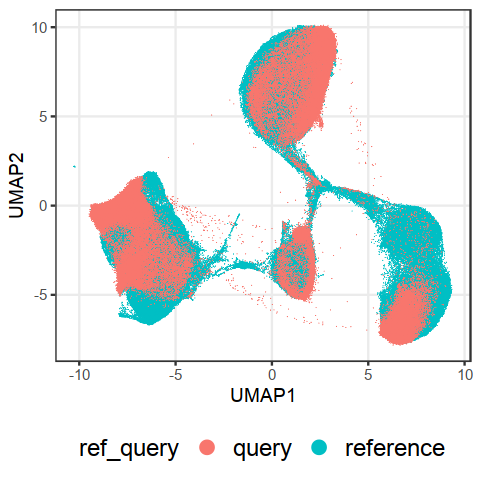

In [64]:
# Plot UMAP visualization
fig.size(4, 4)

q = umap_combined_labels %>%
#     sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = ref_query)) +
    geom_point_rast(size = 0.1, stroke = 0.2, shape = 16) +
    theme_bw() +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="bottom") +
    theme(legend.text = element_text(size=14), plot.title = element_text(size=16), legend.title=element_text(size=14)) + 
    guides(colour = guide_legend(override.aes = list(size = 4))) +
    scale_x_continuous(minor_breaks = seq(-10, 10, 5)) +
    scale_y_continuous(minor_breaks = seq(-10, 10, 5))
q

In [76]:
# # Plot UMAP visualization
# fig.size(4, 11)

# q = umap_combined_labels %>%
#     sample_frac(1L) %>% # permute rows randomly
#     ggplot(aes(x = UMAP1, y = UMAP2, col = cell.type)) +
#     geom_point_rast(size = 0.1, stroke = 0.2, shape = 16) +
#     theme_bw() +
#     theme(plot.title = element_text(hjust = 0.5)) +
#     theme(legend.position="right") +
#     theme(legend.text = element_text(size=20), plot.title = element_text(size=16), 
#           legend.title=element_text(size=20)) + 
#     scale_color_brewer(palette = 'Paired') +
#     guides(colour = guide_legend(override.aes = list(size = 4))) +
#     scale_x_continuous(minor_breaks = seq(-10, 10, 5)) +
#     scale_y_continuous(minor_breaks = seq(-10, 10, 5)) +
#     facet_wrap(~ref_query)
# q

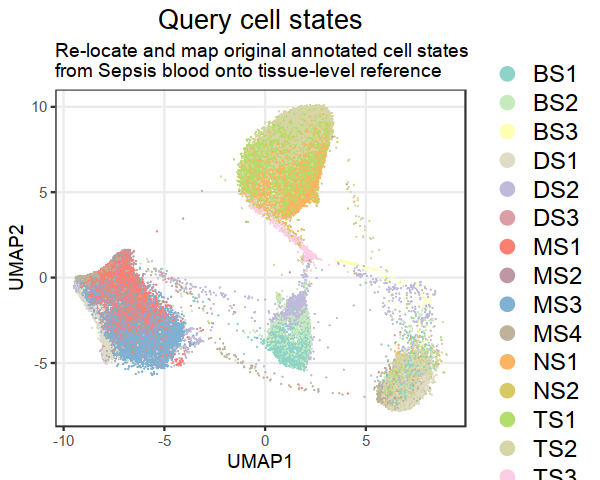

In [79]:
# Plot UMAP visualization
fig.size(4, 5)

# Define the number of colors you want
nb.cols <- 15
mycolors <- colorRampPalette(brewer.pal(8, "Set3"))(nb.cols)

q = umap_combined_labels[umap_combined_labels$ref_query == 'query'] %>%
    sample_frac(1L) %>% # permute rows randomly
    ggplot(aes(x = UMAP1, y = UMAP2, col = as.factor(cell.state))) +
    geom_point_rast(size = 0.4, stroke = 0.2, shape = 16) +
    theme_bw() +
    labs(title = 'Query cell states', subtitle = 'Re-locate and map original annotated cell states\nfrom Sepsis blood onto tissue-level reference', color = '') +
    theme(plot.title = element_text(hjust = 0.5)) +
    theme(legend.position="right") +
    theme(legend.text = element_text(size=14), plot.title = element_text(size=16), 
          legend.title=element_text(size=14)) + 
    scale_color_manual(values = mycolors) +
    guides(colour = guide_legend(override.aes = list(size = 4))) +
    scale_x_continuous(minor_breaks = seq(-10, 10, 5)) +
    scale_y_continuous(minor_breaks = seq(-10, 10, 5))
q

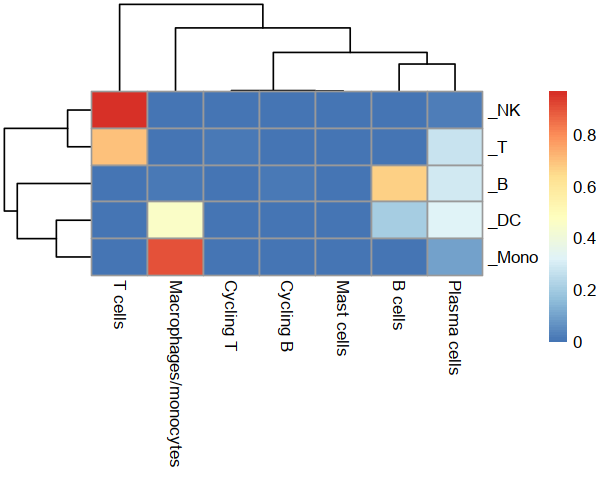

In [74]:
## Cell type mappings heatmap
res = symphony:::evaluate(query$meta_data$cell_type_pred_knn, query$meta_data$cell.type)

fig.size(4,5)
Conf = t(res$Conf) / rowSums(t(res$Conf))
pheatmap(Conf)

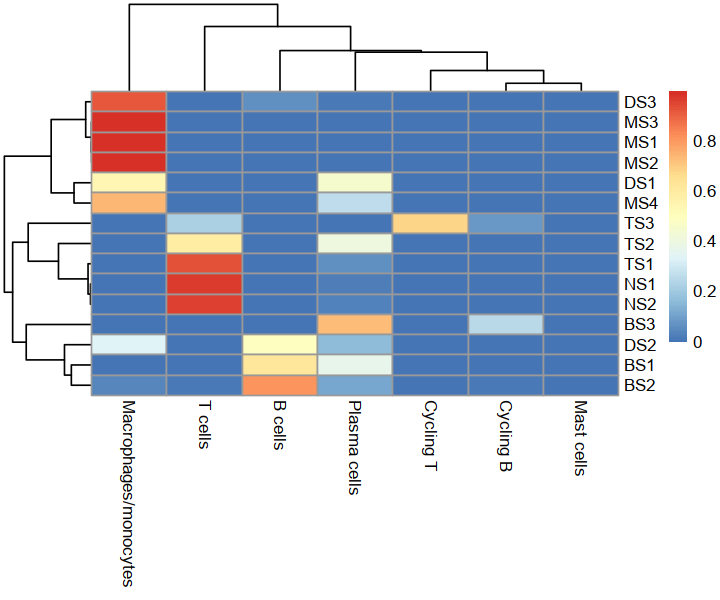

In [75]:
# Cell state mappings heatmap
res = symphony:::evaluate(query$meta_data$cell_type_pred_knn, query$meta_data$cell.state)

fig.size(5,6)
Conf = t(res$Conf) / rowSums(t(res$Conf))
pheatmap(Conf)